# **Prediksi Harga Saham BBRI Menggunakan RNN & LSTM** 
# **`(Load Best Model RNN & LSTM)`**

---

Berikut ini merupakan load model yang telah dilakukan pencarian kombinasi hyperparameter terbaik dengan cara melakukan `Hyperparameter Tuning RandomizedSearchCV.` 

## Install Libraries

In [3]:
%pip install numpy pandas scikeras tensorflow matplotlib scikit-learn==1.5.0

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [1]:
import os  # Interaksi sistem operasi
import numpy as np  # Komputasi numerik
import tensorflow as tf # Deep learning
import pandas as pd # Manipulasi dan analisis data
import math  # Fungsi matematika standar
import logging  # Modul untuk logging
import matplotlib.pyplot as plt # Visualisasi data
from sklearn.preprocessing import MinMaxScaler # Penskalaan data
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error # Metrik Evaluasi

folder_path = "plots"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

## Dataset & Visualization



In [2]:
# Menampilkan dataset saham BBRI
df = pd.read_excel('datasets/BBRI_2010-2025.xlsx')
df

,Date,Open,High,Low,Close,Volume
0,2010-01-04,408.44,411.06,400.59,408.44,125094160
1,2010-01-05,411.06,413.68,408.44,411.06,163644326
2,2010-01-06,405.82,416.29,403.20,405.82,104842810
3,2010-01-07,400.59,405.82,395.35,400.59,101933260
4,2010-01-08,403.20,403.20,395.35,403.20,87237006
...,...,...,...,...,...,...
3696,2024-12-20,3723.15,3768.88,3704.85,3714.00,252689600
3697,2024-12-23,3778.03,3851.21,3759.74,3851.21,167689800
3698,2024-12-24,3860.36,3887.81,3814.62,3842.07,199536100
3699,2024-12-27,3875.15,3894.05,3856.24,3875.15,143104400


### Preprocessing Data

In [3]:
# Memilih kolom date sebagai index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Memilih kolom close untuk prediksi
df= df[['Close']]
df

,Close
Date,
2010-01-04,408.44
2010-01-05,411.06
2010-01-06,405.82
2010-01-07,400.59
2010-01-08,403.20
...,...
2024-12-20,3714.00
2024-12-23,3851.21
2024-12-24,3842.07


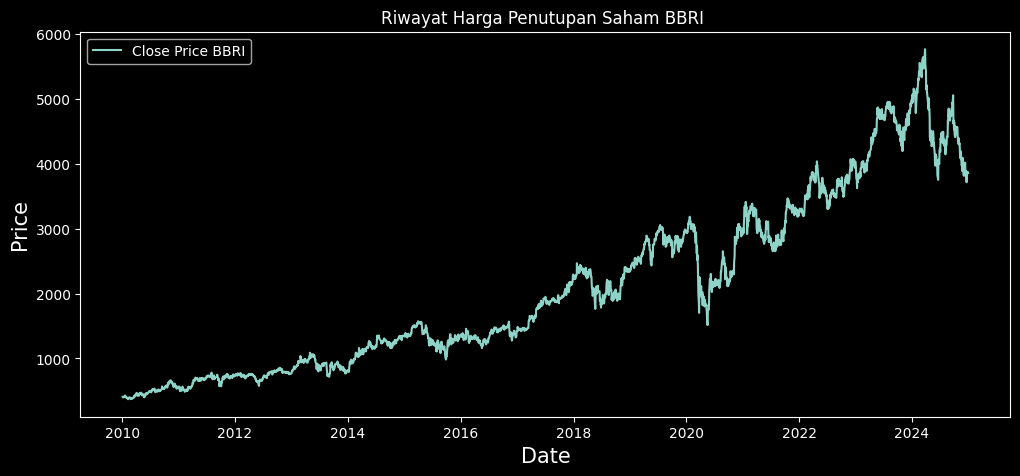

In [4]:
# Visualisasi data harga penutupan
plt.style.use('dark_background')
plt.figure(figsize=(12, 5))
plt.title('Riwayat Harga Penutupan Saham BBRI ')
plt.plot(df['Close'], label='Close Price BBRI')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()

# Simpan plot ke dalam folder dengan resolusi tinggi
file_path = os.path.join(folder_path, 'Historis Harga Penutupan Saham BBRI')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

#### Splitting Data Training `70%`, Validasi `15%` dan Testing `15%`

In [5]:
# Konversi data ke numpy array, Reshape data ke 2D array
data = df.filter(['Close']).values.reshape(-1, 1)

In [6]:
# Rasio pembagian data :
length_data = len(data) 

# Tentukan jumlah data untuk masing-masing set
train_len = math.ceil(length_data * 0.7)  
val_len = int(length_data * 0.15)   
test_len = length_data - (train_len + val_len)  

#### Normalization Data and Sliding Window 

In [7]:
# Normalisasi data dengan metode MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

In [8]:
# Nilai time_step yang ditentukan yaitu 30 hari perdagangan
time_step = 30

In [9]:
# Pembentukan data training dan normalisasi data training
train_set = data[0:train_len]
train_scaled_data = sc.fit_transform(train_set)

# Membuat fungsi untuk pembentukan teknik sliding window
x_train = []
y_train = []

for i in range(time_step, len(train_scaled_data)):
    x_train.append(train_scaled_data[i-time_step:i, 0])
    y_train.append(train_scaled_data[i, 0])
    
# Mengubah tipe data list menjadi numpy array 2D
x_train, y_train = np.array(x_train), np.array(y_train)

# Ubah bentuk data menjadi bentuk yang diterima oleh model ke dalam bentuk 3D (Sample, Time_Step, Feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
y_train = np.reshape(y_train, (y_train.shape[0],1))

In [10]:
# pembentukan data validasi dan normalisasi data
val_set = data[train_len - time_step :(train_len + val_len), :]
val_scaled_data = sc.transform(val_set) 

# Buat fungsi pembentukan teknik sliding window seperti sebelumnya
x_val = []
y_val = []

for i in range(time_step, len(val_scaled_data)):
    x_val.append(val_scaled_data[i - time_step:i, 0])
    y_val.append(val_scaled_data[i, 0])

x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0],1))

In [11]:
# Pembentukan data testing dan normalisasi data
test_set = data[(-test_len - time_step):, :]
test_scaled_data = sc.transform(test_set)

# Pembentukan data untuk melakukan prediksi pada data testing
x_test = []
y_test = df[['Close']].iloc[-test_len :, :].values
for i in range(time_step, len(test_scaled_data )):
    x_test.append(test_scaled_data [i-time_step:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# RNN Model

### Load Best Model RNN

In [12]:
# Memuat model terbaik yang telah disimpan sebelumnya (termasuk bobot dan arsitektur)
logging.info("Memuat model terbaik yang telah disimpan...")
best_model_RNN = tf.keras.models.load_model("model_checkpoints/best_RNN_model.keras")
best_model_RNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

In [15]:
# Folder utama
main_folder = "RNN-LSTM_Weights_All_Layers"
os.makedirs(main_folder, exist_ok=True)

# Subfolder untuk RNN
RNN_folder = os.path.join(main_folder, "RNN_Weights_All_Layers")
os.makedirs(RNN_folder, exist_ok=True)

# Loop semua layer dalam model RNN
for i, layer in enumerate(best_model_RNN.layers):
    layer_folder = os.path.join(RNN_folder, f"Layer_{i}_{layer.name}")
    os.makedirs(layer_folder, exist_ok=True)

    weights = layer.get_weights()

    # Menyimpan bobot dan bias hanya jika layer memiliki bobot
    if weights:
        # Jika layer adalah SimpleRNN
        if isinstance(layer, tf.keras.layers.SimpleRNN):
            if len(weights) == 3:  # SimpleRNN memiliki 3 elemen: kernel, recurrent_kernel, dan bias
                kernel, recurrent_kernel, bias = weights

                # Simpan bobot dan bias dalam file terpisah
                with open(os.path.join(layer_folder, "rnn_weights.txt"), "w") as fw:
                    fw.write("[SimpleRNN Weights]\n")
                    fw.write("Input Kernel (Bobot):\n")
                    fw.write(f"{kernel}\n\n")
                    fw.write("Recurrent Kernel (Bobot):\n")
                    fw.write(f"{recurrent_kernel}\n")

                with open(os.path.join(layer_folder, "rnn_bias.txt"), "w") as fb:
                    fb.write("[SimpleRNN Bias]\n")
                    fb.write(f"{bias}\n")

        elif isinstance(layer, tf.keras.layers.Dense):
            # Jika layer adalah Dense
            kernel, bias = weights

            # Simpan bobot dan bias dalam file terpisah
            with open(os.path.join(layer_folder, "dense_weights.txt"), "w") as fw:
                fw.write("[Dense Weights]\n")
                fw.write(f"{kernel}\n")

            with open(os.path.join(layer_folder, "dense_bias.txt"), "w") as fb:
                fb.write("[Dense Bias]\n")
                fb.write(f"{bias}\n")
    else:
        # Jika layer tidak memiliki bobot atau bias (misalnya Dropout)
        with open(os.path.join(layer_folder, "info.txt"), "w") as f:
            f.write(f"Layer '{layer.name}' ({type(layer).__name__}) tidak memiliki bobot atau bias.\n")

print(f"✅ Semua bobot dan bias model RNN berhasil disimpan di: {RNN_folder}")


✅ Semua bobot dan bias model RNN berhasil disimpan di: RNN-LSTM_Weights_All_Layers\RNN_Weights_All_Layers


### Load Training Result RNN

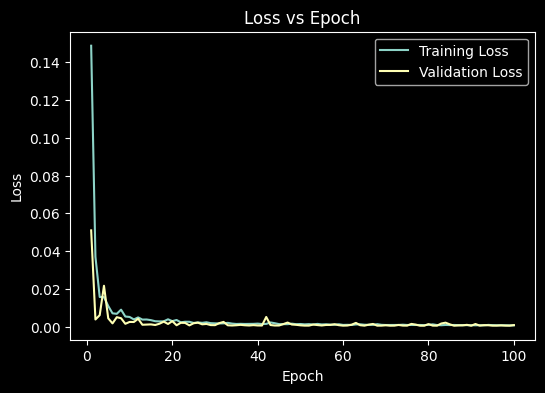

In [14]:
# Load CSV
df_loss_RNN = pd.read_csv("training_results/RNN_loss_history.csv")

# Plot loss
plt.style.use('dark_background')
plt.figure(figsize=(6,4))
plt.plot(df_loss_RNN["epoch"], df_loss_RNN["training_loss"], label="Training Loss") 
plt.plot(df_loss_RNN["epoch"], df_loss_RNN["validation_loss"], label="Validation Loss") 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# Simpan plot ke dalam folder dengan resolusi tinggi
file_path = os.path.join(folder_path, 'RNN_Training and validation loss vs Epoch')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

## RNN Prediction

In [13]:
# Proses prediksi
y_pred_RNN = best_model_RNN.predict(x_test)
y_pred_RNN = sc.inverse_transform(y_pred_RNN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [14]:
# Prediksi data tesing
df_pred_RNN = df[-test_len:].copy()
df_pred_RNN['Prediction'] = np.round(y_pred_RNN, 2)

# Atur tampilan float agar hanya 2 angka di belakang koma
pd.set_option('display.float_format', '{:.2f}'.format)
df_pred_RNN

,Close,Prediction
Date,,
2022-09-13,3741.92,3716.05
2022-09-14,3741.92,3735.75
2022-09-15,3766.43,3731.23
2022-09-16,3676.56,3743.94
2022-09-19,3733.75,3676.16
...,...,...
2024-12-20,3714.00,3727.98
2024-12-23,3851.21,3706.31
2024-12-24,3842.07,3805.00


In [16]:
# Evaluasi dengan metrik
mse = mean_squared_error(y_test, y_pred_RNN)
rmse = root_mean_squared_error(y_test, y_pred_RNN)
mae = mean_absolute_error(y_test, y_pred_RNN)

# Evaluasi model yang dimuat
print(f'Testing Data Performance Metrics :')
print(f'=====================================')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}\n')

training_loss = best_model_RNN.evaluate(x_train, y_train, verbose=2)
validation_loss = best_model_RNN.evaluate(x_val, y_val, verbose=2)
testing_loss = mean_squared_error(sc.transform(y_test), sc.transform(y_pred_RNN)) 

print(f"\nTraining Loss: {training_loss:.6f}")
print(f"Validation Loss: {validation_loss:.6f}")
print(f"Testing Loss (In Normalized): {testing_loss:.6f}")

Testing Data Performance Metrics :
Mean Squared Error (MSE): 9340.06
Root Mean Squared Error (RMSE): 96.64
Mean Absolute Error (MAE): 76.57

81/81 - 0s - 6ms/step - loss: 1.4500e-04
18/18 - 0s - 9ms/step - loss: 4.5832e-04

Training Loss: 0.000145
Validation Loss: 0.000458
Testing Loss (In Normalized): 0.001182


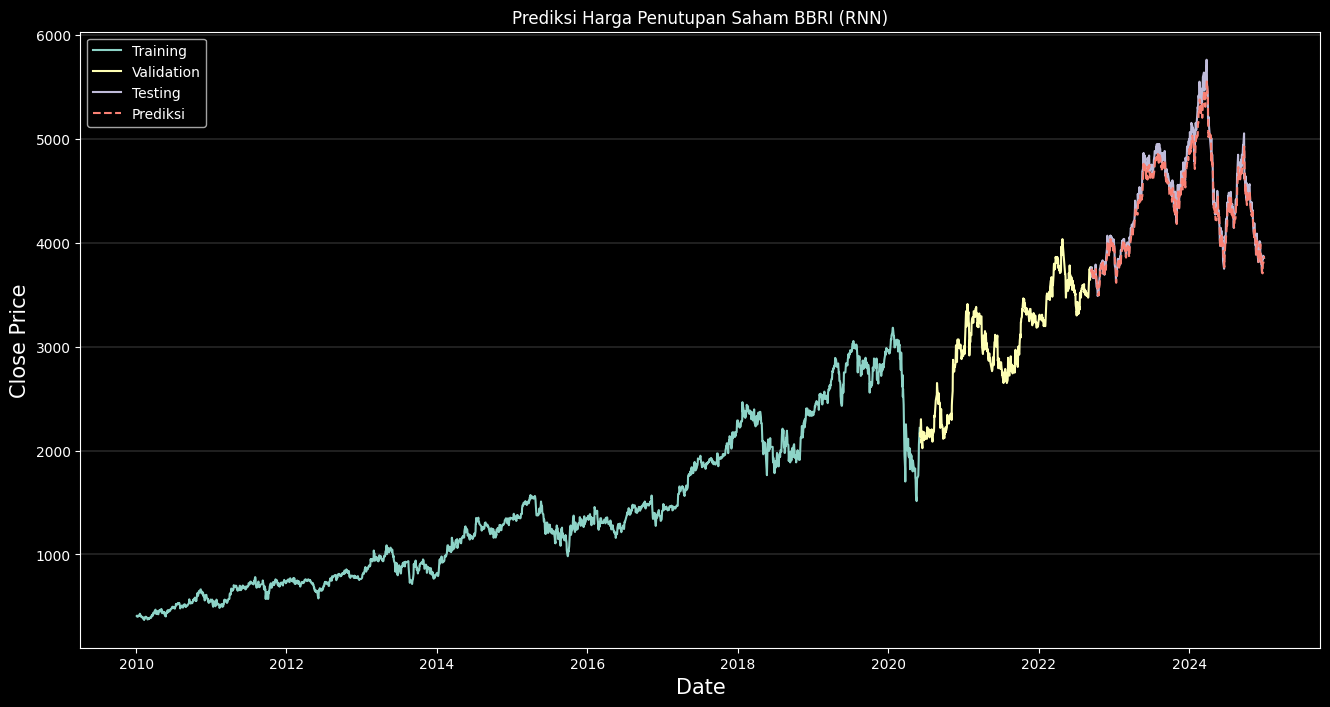

In [17]:
# Membuat data untuk visualisasi
train = df[:train_len]
valid = df[train_len:(train_len + val_len)]

# visualisasi prediksi
plt.figure(figsize=(16, 8))
plt.title('Prediksi Harga Penutupan Saham BBRI (RNN)')
plt.plot(train.index, train['Close'], label='Training') 
plt.plot(valid.index, valid['Close'], label='Validation') 
plt.plot(df_pred_RNN.index, df_pred_RNN['Close'], label='Testing') 
plt.plot(df_pred_RNN.index, df_pred_RNN['Prediction'], label='Prediksi', linestyle='--') 
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

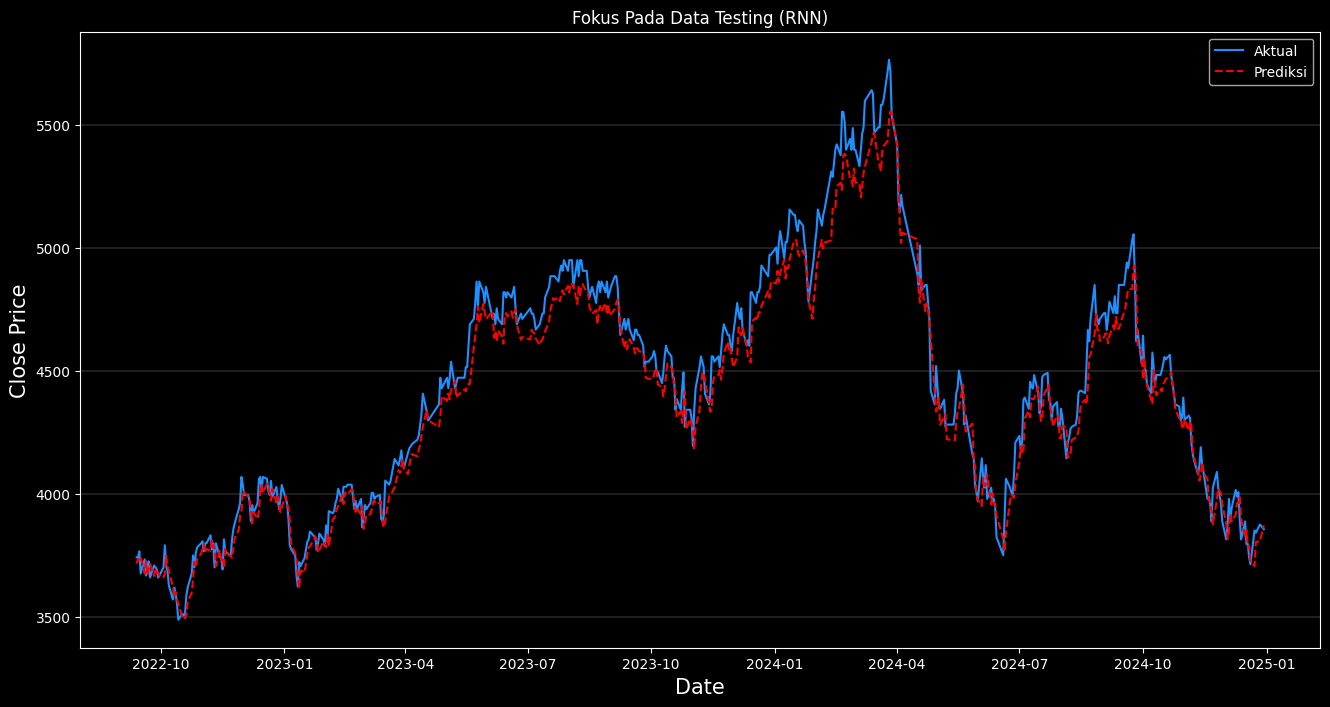

In [18]:
# Fokus kepada data testing
plt.figure(figsize=(16, 8))
plt.title('Fokus Pada Data Testing (RNN)')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.plot(df_pred_RNN.index, df_pred_RNN['Close'], label='Aktual', color='#1E90ff')
plt.plot(df_pred_RNN.index, df_pred_RNN['Prediction'], label='Prediksi', color='red', linestyle='--')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

# LSTM Model

### Load Best Model LSTM

In [19]:
# Memuat model terbaik yang telah disimpan sebelumnya (termasuk bobot dan arsitektur)
logging.info("Memuat model terbaik yang telah disimpan...")
best_model_LSTM = tf.keras.models.load_model("model_checkpoints/best_LSTM_model.keras")
best_model_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,349 (3.03 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 528,900 (2.02 MB)

In [20]:
# Folder utama
main_folder = "RNN-LSTM_Weights_All_Layers"
os.makedirs(main_folder, exist_ok=True)

# Subfolder untuk LSTM
lstm_folder = os.path.join(main_folder, "LSTM_Weights_All_Layers")
os.makedirs(lstm_folder, exist_ok=True)

# Loop semua layer dalam model LSTM
for i, layer in enumerate(best_model_LSTM.layers):
    layer_folder = os.path.join(lstm_folder, f"Layer_{i}_{layer.name}")
    os.makedirs(layer_folder, exist_ok=True)

    weights = layer.get_weights()

    if weights:
        if isinstance(layer, tf.keras.layers.LSTM) and len(weights) == 3:
            kernel, recurrent_kernel, bias = weights

            # Split menjadi 4 gate
            bi, bf, bc, bo = np.split(kernel, 4, axis=1)
            rbi, rbf, rbc, rbo = np.split(recurrent_kernel, 4, axis=1)
            bi_bias, bf_bias, bc_bias, bo_bias = np.split(bias, 4)

            # Simpan bobot ke lstm_weights.txt
            with open(os.path.join(layer_folder, "lstm_weights.txt"), "w") as fw:
                fw.write("[LSTM Weights]\n")
                fw.write("Input Gate Kernel:\n"); fw.write(f"{bi}\n\n")
                fw.write("Forget Gate Kernel:\n"); fw.write(f"{bf}\n\n")
                fw.write("Cell Gate Kernel:\n"); fw.write(f"{bc}\n\n")
                fw.write("Output Gate Kernel:\n"); fw.write(f"{bo}\n\n")

                fw.write("Input Gate Recurrent Kernel:\n"); fw.write(f"{rbi}\n\n")
                fw.write("Forget Gate Recurrent Kernel:\n"); fw.write(f"{rbf}\n\n")
                fw.write("Cell Gate Recurrent Kernel:\n"); fw.write(f"{rbc}\n\n")
                fw.write("Output Gate Recurrent Kernel:\n"); fw.write(f"{rbo}\n")

            # Simpan bias ke lstm_bias.txt
            with open(os.path.join(layer_folder, "lstm_bias.txt"), "w") as fb:
                fb.write("[LSTM Bias]\n")
                fb.write("Input Gate Bias:\n"); fb.write(f"{bi_bias}\n\n")
                fb.write("Forget Gate Bias:\n"); fb.write(f"{bf_bias}\n\n")
                fb.write("Cell Gate Bias:\n"); fb.write(f"{bc_bias}\n\n")
                fb.write("Output Gate Bias:\n"); fb.write(f"{bo_bias}\n")
        else:
            # Untuk Dense atau layer lain
            for j, w in enumerate(weights):
                filename = "weights.txt" if j == 0 else "bias.txt"
                label = "Bobot" if j == 0 else "Bias"
                with open(os.path.join(layer_folder, filename), "a") as f:
                    f.write(f"[{type(layer).__name__}] {label} ke-{j}:\n")
                    f.write(f"{w}\n\n")
    else:
        with open(os.path.join(layer_folder, "info.txt"), "w") as f:
            f.write(f"Layer '{layer.name}' ({type(layer).__name__}) tidak memiliki bobot atau bias.\n")

print(f"✅ Semua bobot dan bias model LSTM berhasil disimpan di: {lstm_folder}")

✅ Semua bobot dan bias model LSTM berhasil disimpan di: RNN-LSTM_Weights_All_Layers\LSTM_Weights_All_Layers


### Load Training Result LSTM

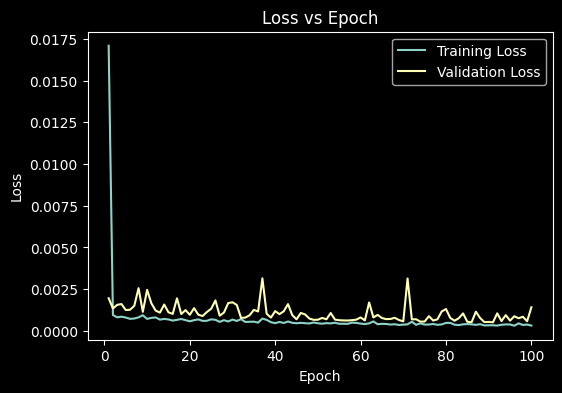

In [38]:
# Load CSV
df_loss_LSTM = pd.read_csv("training_results/LSTM_loss_history.csv")

# Plot loss
plt.style.use('dark_background')
plt.figure(figsize=(6,4))
plt.plot(df_loss_LSTM ["epoch"], df_loss_LSTM ["training_loss"], label="Training Loss")
plt.plot(df_loss_LSTM ["epoch"], df_loss_LSTM ["validation_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
# Simpan plot ke dalam folder dengan resolusi tinggi
file_path = os.path.join(folder_path, 'LSTM_Training and validation loss vs Epoch')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

## LSTM Prediction

In [21]:
# Proses prediksi
y_pred_LSTM = best_model_LSTM.predict(x_test)
y_pred_LSTM = sc.inverse_transform(y_pred_LSTM)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [22]:
# Prediksi data testing
df_pred_LSTM = df[-test_len:].copy()
df_pred_LSTM['Prediction'] = np.round(y_pred_LSTM, 2)

# Atur tampilan float agar hanya 2 angka di belakang koma
pd.set_option('display.float_format', '{:.2f}'.format)
df_pred_LSTM

,Close,Prediction
Date,,
2022-09-13,3741.92,3748.41
2022-09-14,3741.92,3744.14
2022-09-15,3766.43,3742.94
2022-09-16,3676.56,3756.96
2022-09-19,3733.75,3719.16
...,...,...
2024-12-20,3714.00,3767.10
2024-12-23,3851.21,3730.03
2024-12-24,3842.07,3788.01


In [23]:
# Evaluasi dengan metrik
mse = mean_squared_error(y_test, y_pred_LSTM)
rmse = root_mean_squared_error(y_test, y_pred_LSTM)
mae = mean_absolute_error(y_test, y_pred_LSTM)

# Evaluasi model yang dimuat
print(f'Testing Data Performance Metrics :')
print(f'=====================================')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}\n')

training_loss = best_model_LSTM.evaluate(x_train, y_train, verbose=2)
validation_loss = best_model_LSTM.evaluate(x_val, y_val, verbose=2)
testing_loss = mean_squared_error(sc.transform(y_test), sc.transform(y_pred_LSTM)) 

print(f"\nTraining Loss: {training_loss:.6f}")
print(f"Validation Loss: {validation_loss:.6f}")
print(f"Testing Loss (In Normalized): {testing_loss:.6f}")

Testing Data Performance Metrics :
Mean Squared Error (MSE): 5535.33
Root Mean Squared Error (RMSE): 74.40
Mean Absolute Error (MAE): 57.26

81/81 - 2s - 25ms/step - loss: 1.8600e-04
18/18 - 0s - 14ms/step - loss: 5.1771e-04

Training Loss: 0.000186
Validation Loss: 0.000518
Testing Loss (In Normalized): 0.000701


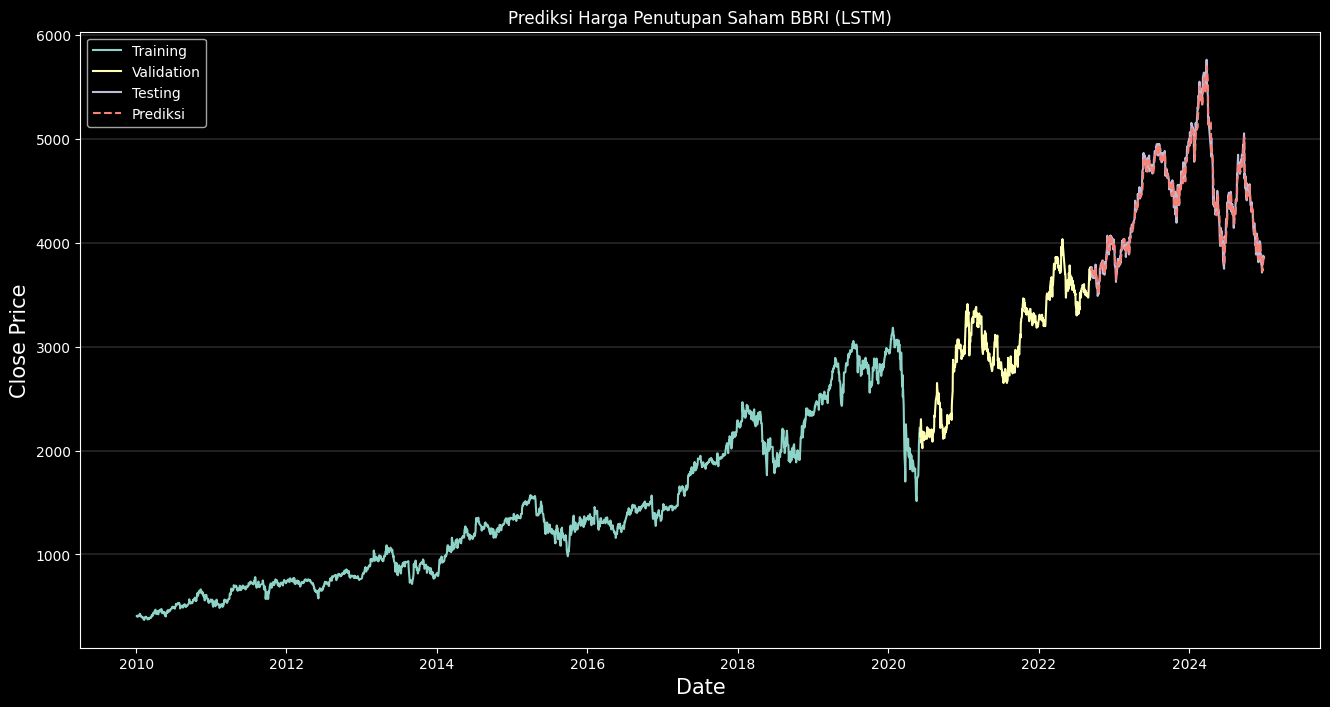

In [24]:
# Membuat data untuk visualisasi
train = df[:train_len]
valid = df[train_len:(train_len + val_len)]

# visualisasi prediksi
plt.figure(figsize=(16, 8))
plt.title('Prediksi Harga Penutupan Saham BBRI (LSTM)')
plt.plot(train.index, train['Close'], label='Training') 
plt.plot(valid.index, valid['Close'], label='Validation')
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Close'], label='Testing') 
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Prediction'], label='Prediksi', linestyle='--') 
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

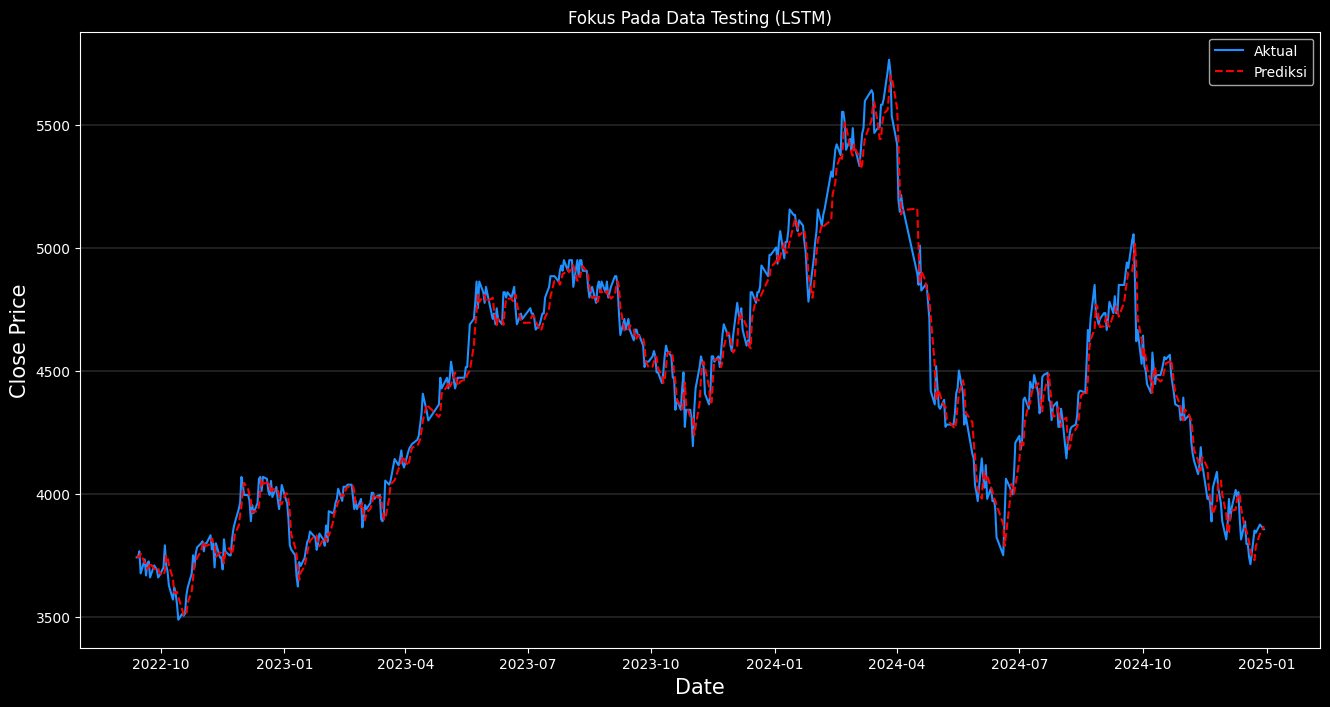

In [25]:
# Fokus kepada data testing
plt.figure(figsize=(16, 8))
plt.title('Fokus Pada Data Testing (LSTM)')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Close'], label='Aktual', color='#1E90ff')
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Prediction'], label='Prediksi', color='red', linestyle='--')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

# RNN vs LSTM Prediction

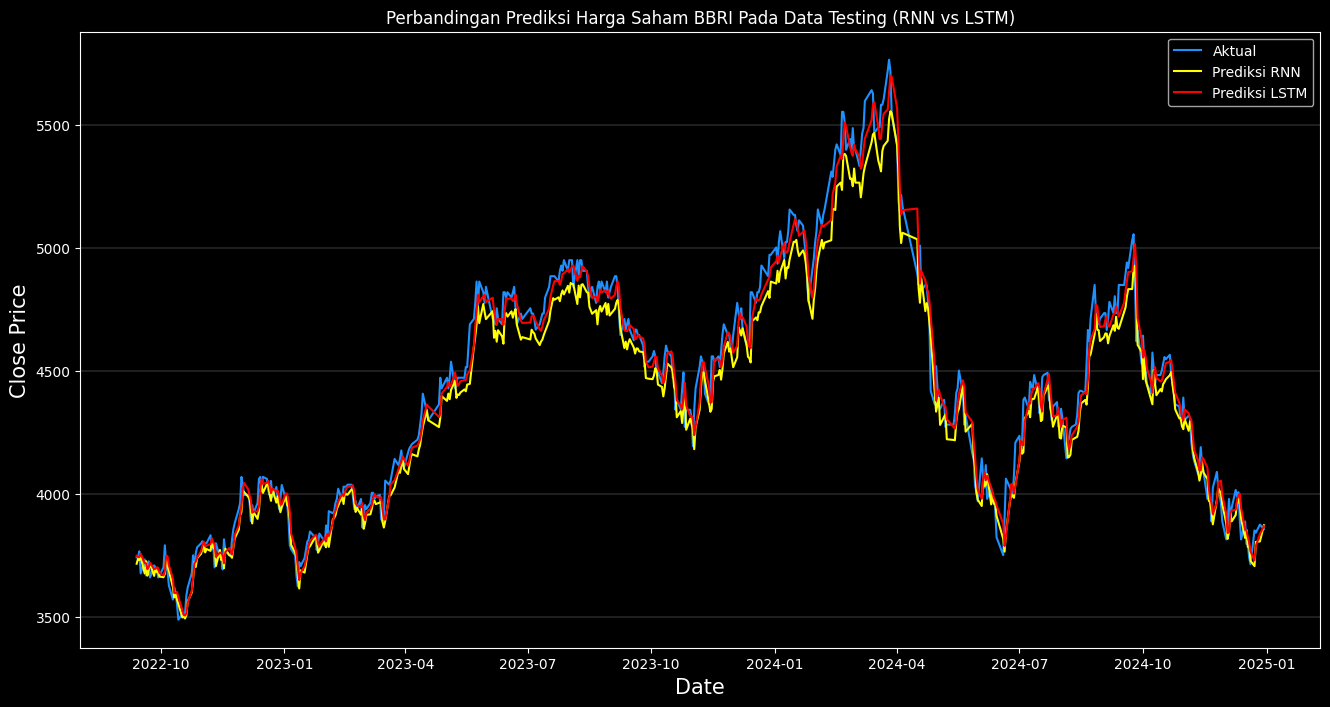

In [26]:
# Fokus kepada data testing anatara RNN dan LSTM
plt.figure(figsize=(16, 8))
plt.title('Perbandingan Prediksi Harga Saham BBRI Pada Data Testing (RNN vs LSTM)')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.plot(df_pred_RNN.index, df_pred_RNN['Close'], label='Aktual', color='#1E90ff')
plt.plot(df_pred_RNN.index, df_pred_RNN['Prediction'], label='Prediksi RNN', color='yellow')
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Prediction'], label='Prediksi LSTM', color='red')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')

# Simpan plot ke dalam folder dengan resolusi tinggi
file_path = os.path.join(folder_path, 'RNN_vs_LSTM.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

# RNN vs LSTM Prediction T+7

In [27]:
# === Ambil 30 hari terakhir dan skala data ===
last_30_days = df['Close'][-time_step:].values.reshape(-1, 1)
last_30_days_scaled = sc.transform(last_30_days)

# === Siapkan input untuk prediksi RNN dan LSTM ===
temp_input_rnn = list(last_30_days_scaled.copy())
temp_input_lstm = list(last_30_days_scaled.copy())

# === Tempat menyimpan hasil prediksi ===
predicted_price_RNN_scaled = []
predicted_price_LSTM_scaled = []

# === Prediksi 7 hari ke depan ===
for i in range(7):
    # === Prediksi RNN ===
    x_rnn = np.array(temp_input_rnn[-time_step:]).reshape(1, time_step, 1)
    pred_rnn = best_model_RNN.predict(x_rnn, verbose=0)
    predicted_price_RNN_scaled.append(pred_rnn[0][0])
    temp_input_rnn.append([pred_rnn[0][0]])  

    # === Prediksi LSTM ===
    x_lstm = np.array(temp_input_lstm[-time_step:]).reshape(1, time_step, 1)
    pred_lstm = best_model_LSTM.predict(x_lstm, verbose=0)
    predicted_price_LSTM_scaled.append(pred_lstm[0][0])
    temp_input_lstm.append([pred_lstm[0][0]])

# === Kembalikan ke skala harga asli ===
predicted_price_RNN = sc.inverse_transform(np.array(predicted_price_RNN_scaled).reshape(-1, 1))
predicted_price_LSTM = sc.inverse_transform(np.array(predicted_price_LSTM_scaled).reshape(-1, 1))

# === Tampilkan hasil prediksi ===
print("Hasil Prediksi 7 Hari ke Depan:")
print("-" * 40)
for i in range(7):
    print(f"Hari ke-{i+1:2d} | RNN: {predicted_price_RNN[i][0]:.2f} | LSTM: {predicted_price_LSTM[i][0]:.2f}")


Hasil Prediksi 7 Hari ke Depan:
----------------------------------------
Hari ke- 1 | RNN: 3838.24 | LSTM: 3866.99
Hari ke- 2 | RNN: 3811.70 | LSTM: 3863.08
Hari ke- 3 | RNN: 3812.77 | LSTM: 3860.44
Hari ke- 4 | RNN: 3806.18 | LSTM: 3859.14
Hari ke- 5 | RNN: 3791.67 | LSTM: 3858.67
Hari ke- 6 | RNN: 3770.19 | LSTM: 3858.61
Hari ke- 7 | RNN: 3743.83 | LSTM: 3858.67


In [38]:
import yfinance as yf
from datetime import datetime, timedelta

# Ambil data sampai 30 hari ke depan 
start_date = datetime(2025, 1, 1)
end_date = start_date + timedelta(days=30)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

# Ambil data
ticker = 'BBRI.JK'
bbri_data = yf.download(ticker, start=start_str, end=end_str)
bbri_close = bbri_data[['Close']]
bbri_close_30 = bbri_close.head(7)
bbri_close_30

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BBRI.JK']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Close
Ticker,BBRI.JK
Date,


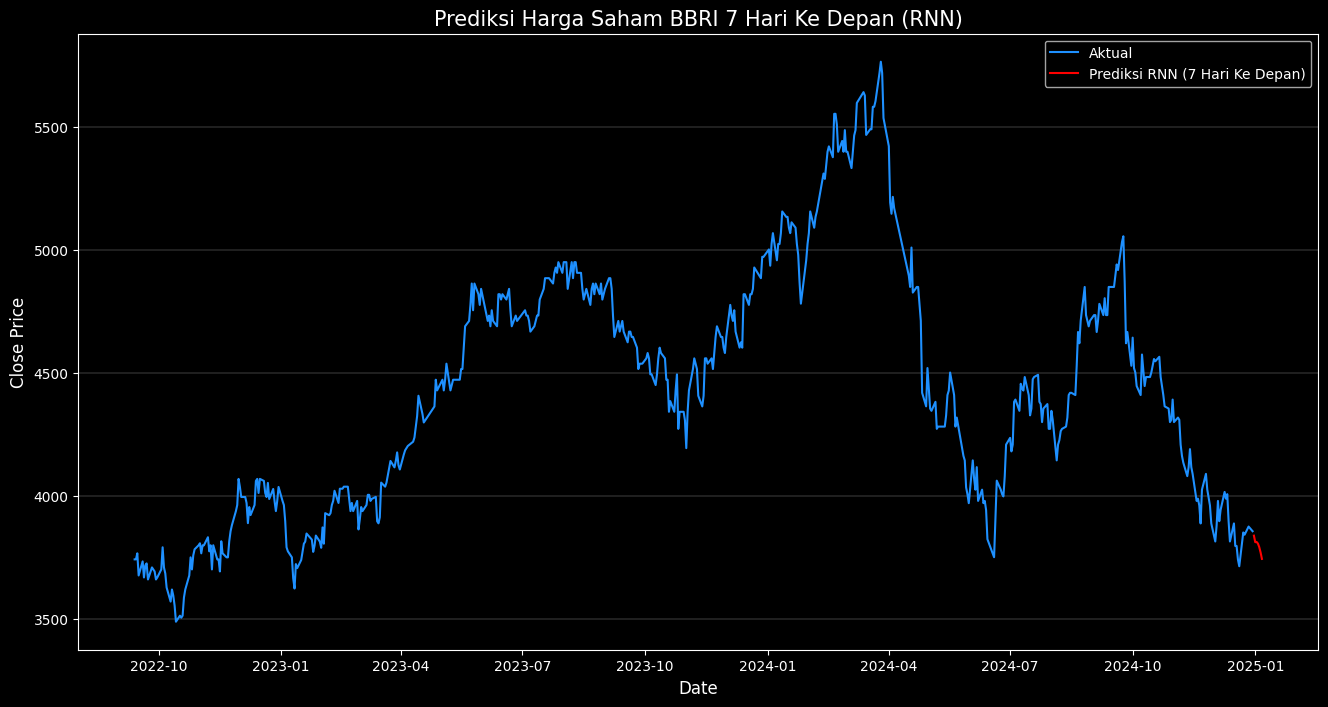

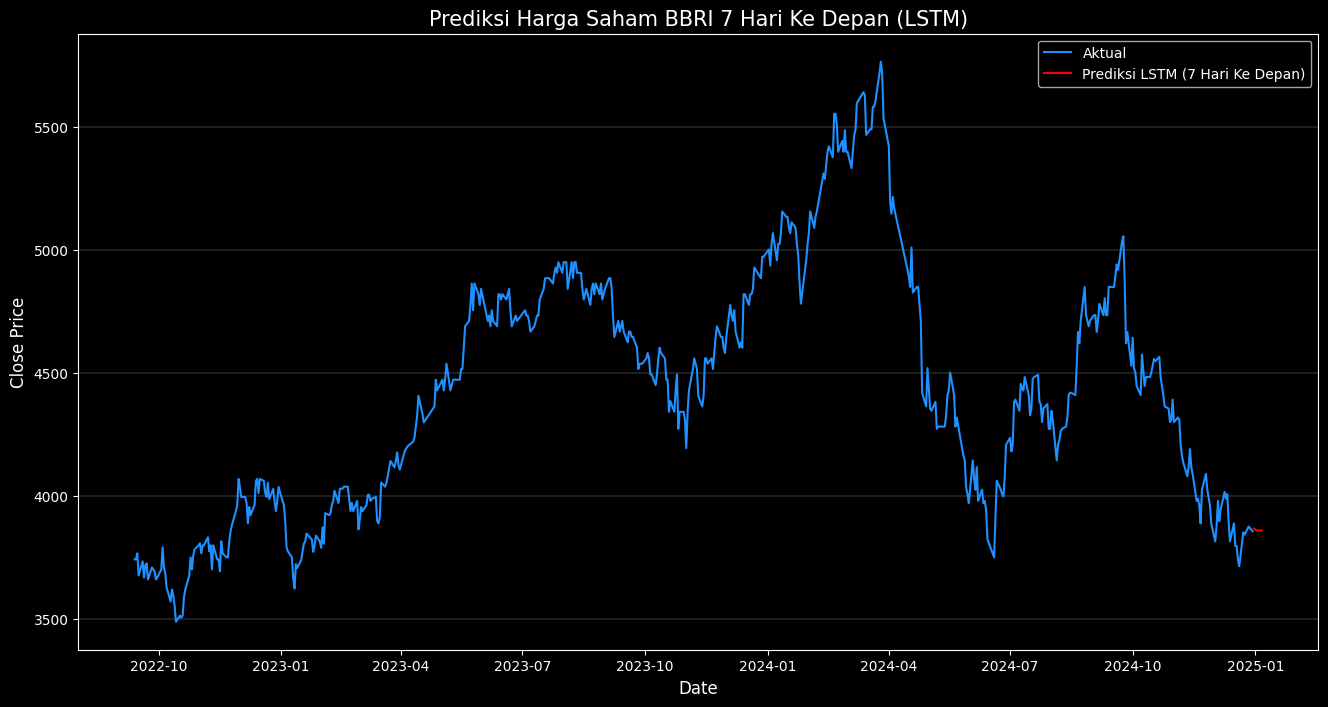

In [46]:
def plot_future_prediction(df_pred, predicted_price, model_name, file_name):
    last_date = df_pred.index[-1]
    future_dates = pd.date_range(start=last_date, periods=8, freq='D')[1:]
    predicted_price = predicted_price.flatten()  

    # Buat grafik
    plt.figure(figsize=(16, 8))
    plt.plot(df_pred.index, df_pred['Close'], label='Aktual', color='#1E90ff')
    plt.plot(future_dates, predicted_price, label=f'Prediksi {model_name} (7 Hari Ke Depan)', color='red', linestyle='-')
    plt.title(f'Prediksi Harga Saham BBRI 7 Hari Ke Depan ({model_name})', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend()
    plt.grid(True, linewidth=0.18, axis='y')
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()
    
# Plot untuk RNN dan LSTM
plot_future_prediction(df_pred_RNN, predicted_price_RNN, 'RNN', 'RNN_Prediksi_7_Hari_Ke_Depan.png')
plot_future_prediction(df_pred_LSTM, predicted_price_LSTM, 'LSTM', 'LSTM_Prediksi_7_Hari_Ke_Depan.png')
